## Seccion 1: Imports y Configuracion de Rutas

In [15]:
# Importamos las librerias necesarias para manipulacion de datos, visualizacion,
# preprocesamiento, entrenamiento, evaluacion y serializacion de modelos.
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

# Rutas base del proyecto. BASE_DIR apunta al directorio de trabajo actual,
# que debe ser la carpeta "training/" para que las rutas relativas sean correctas.
BASE_DIR: str = os.path.abspath(os.getcwd())
DB_DIR: str = os.path.join(BASE_DIR, "database")
CLEAN_DIR: str = os.path.join(DB_DIR, "clean")
MODEL_DIR: str = os.path.join(BASE_DIR, "models")

# Dataset principal: temporadas 2016-2024, utilizado para entrenamiento.
# Los datasets de 2022 y 2023 se reservan para evaluacion externa del modelo final.
PATH_TRAIN: str = os.path.join(CLEAN_DIR, "2016-2024_liga_mx_clean.csv")
PATH_TEST_2023: str = os.path.join(CLEAN_DIR, "2016-2023_liga_mx_clean.csv")
PATH_TEST_2022: str = os.path.join(CLEAN_DIR, "2016-2022_liga_mx_clean.csv")
PATH_RAW_2023: str = os.path.join(CLEAN_DIR, "2016-2023_liga_mx_clean.csv")
PATH_RAW_2022: str = os.path.join(CLEAN_DIR, "2016-2022_liga_mx_clean.csv")


## Seccion 2: Carga del Dataset

In [16]:
# Cargamos el dataset de entrenamiento y revisamos su estructura inicial
# (dimensiones y nombres de columnas) antes de aplicar cualquier transformacion.
df_train = pd.read_csv(PATH_TRAIN)
df_train.shape, df_train.columns.tolist()


((2589, 10),
 ['home_team',
  'away_team',
  'home_win',
  'away_win',
  'home_goals',
  'away_goals',
  'home_goals_half_time',
  'away_goals_half_time',
  'home_goals_fulltime',
  'away_goals_fulltime'])

## Seccion 3: Limpieza y Preparacion de Features / Etiquetas

In [17]:
# Eliminamos filas con valores nulos en columnas criticas para no introducir
# ruido en el entrenamiento.
df_train = df_train.dropna(subset=["home_team", "away_team", "home_goals_fulltime", "away_goals_fulltime"])

# Derivamos la etiqueta de resultado del partido a partir de los goles al final:
#   H (Home win) -> equipo local anota mas goles
#   A (Away win) -> equipo visitante anota mas goles
#   D (Draw)     -> ambos equipos anotan los mismos goles
df_train["result"] = np.where(
    df_train["home_goals_fulltime"] > df_train["away_goals_fulltime"], "H",
    np.where(df_train["home_goals_fulltime"] < df_train["away_goals_fulltime"], "A", "D")
)

# Definimos el vector de entrada: equipos local y visitante, y goles al medio tiempo.
# Los goles al medio tiempo son el unico contexto disponible en el momento de la prediccion.
features = ["home_team", "away_team", "home_goals_half_time", "away_goals_half_time"]
df_train = df_train.dropna(subset=features)

X = df_train[features].copy()
y = df_train["result"].copy()

X.shape, y.value_counts(normalize=True)


((2589, 4),
 result
 H    0.454616
 A    0.288915
 D    0.256470
 Name: proportion, dtype: float64)

## Seccion 4: Analisis Exploratorio

In [18]:
# Estadisticas descriptivas de las variables numericas para detectar rangos,
# posibles outliers y diferencias entre goles al medio tiempo y al final.
df_train[["home_goals_half_time","away_goals_half_time","home_goals_fulltime","away_goals_fulltime"]].describe()


,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime
count,2589.000000,2589.000000,2589.000000,2589.000000
mean,0.700657,0.539204,1.562379,1.193897
std,0.821609,0.718294,1.234983,1.083219
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000
max,6.000000,5.000000,9.000000,6.000000


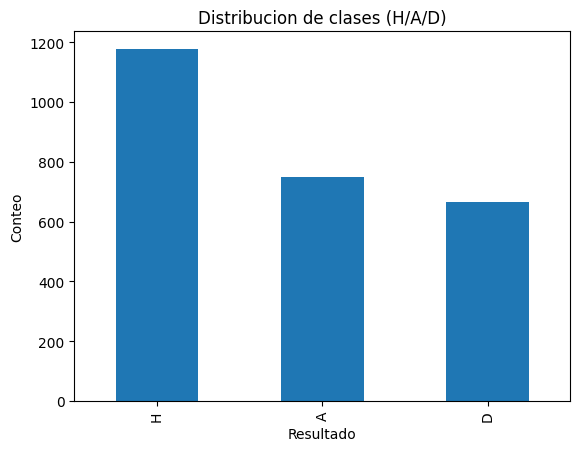

In [19]:
# Distribucion de clases. Verificamos si existe desbalance entre H, A y D,
# lo cual influye en la eleccion de la metrica de evaluacion (f1_macro).
ax = y.value_counts().plot(kind="bar")
ax.set_title("Distribucion de clases (H/A/D)")
ax.set_xlabel("Resultado")
ax.set_ylabel("Conteo")
plt.show()


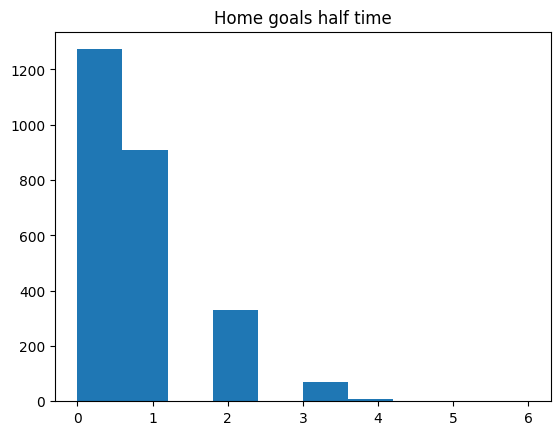

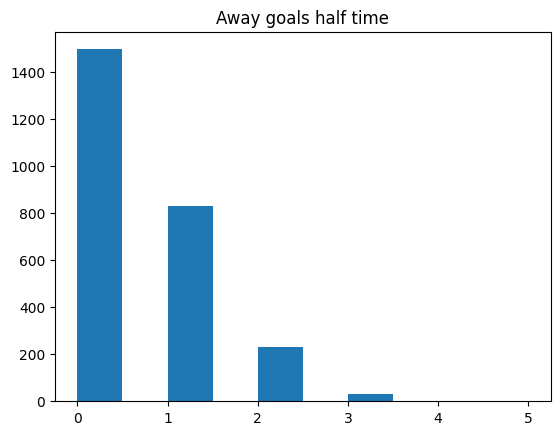

In [20]:
# Distribucion de goles al medio tiempo por equipo local y visitante.
# Nos permite confirmar que los datos siguen una distribucion de conteos (valores enteros >= 0),
# lo cual es relevante para la eleccion del modelo de regresion.
plt.hist(df_train["home_goals_half_time"], bins=10)
plt.title("Home goals half time")
plt.show()

plt.hist(df_train["away_goals_half_time"], bins=10)
plt.title("Away goals half time")
plt.show()

## Seccion 5: Split Entrenamiento / Prueba

In [21]:
# Dividimos el dataset en 80% entrenamiento y 20% prueba.
# Usamos stratify=y para preservar la proporcion de clases (H/A/D) en ambos conjuntos.
# La validacion interna de hiperparametros se realiza mediante cross-validation dentro del GridSearchCV.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

X_train.shape, X_test.shape


((2071, 4), (518, 4))

## Seccion 6: Preprocesamiento

In [22]:
# Definimos el transformador de columnas:
#   - Variables categoricas (equipos): codificacion one-hot ignorando categorias desconocidas
#     para que el modelo pueda manejar equipos no vistos en entrenamiento.
#   - Variables numericas (goles al medio tiempo): estandarizacion con media 0 y desviacion 1.
# Este preprocesador se reutiliza dentro de cada pipeline de modelo.
cat_features = ["home_team", "away_team"]
num_features = ["home_goals_half_time", "away_goals_half_time"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
    ],
    remainder="drop"
)


## Seccion 7: Configuracion de Cross-Validation y Metrica Objetivo

In [23]:
# Usamos StratifiedKFold para los clasificadores: garantiza que cada fold conserve
# la proporcion de clases, evitando folds con clases subrepresentadas.
# La metrica objetivo es f1_macro, que trata todas las clases (H, A, D) con igual
# peso sin importar su frecuencia en el dataset.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"


## Seccion 8: Modelo 1 - Regresion Logistica

In [24]:
# Construimos el pipeline de Regresion Logistica con el preprocesador definido.
# Buscamos los mejores hiperparametros de regularizacion (C) y manejo de desbalance
# de clases mediante GridSearchCV con 5-fold estratificado.
pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000))
])

# Espacio de busqueda:
#   C: fuerza de regularizacion inversa (menor C = mayor regularizacion)
#   class_weight: "balanced" pondera las clases segun su frecuencia para mitigar desbalance
param_grid_lr = {
    "model__C": [0.1, 1, 10],
    "model__solver": ["lbfgs"],
    "model__class_weight": [None, "balanced"]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_lr.fit(X_train, y_train)
grid_lr.best_params_, grid_lr.best_score_


({'model__C': 0.1,
  'model__class_weight': 'balanced',
  'model__solver': 'lbfgs'},
 np.float64(0.5566146093030133))

## Seccion 9: Modelo 2 - Random Forest Clasificador

In [25]:
# Construimos el pipeline de Random Forest Clasificador.
# Exploramos profundidad del arbol, numero de estimadores y manejo de desbalance.
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

# Espacio de busqueda:
#   n_estimators: numero de arboles en el ensemble (mas arboles = mayor estabilidad, mayor costo)
#   max_depth: profundidad maxima de cada arbol (None = sin limite, puede causar overfitting)
#   min_samples_split: minimo de muestras para dividir un nodo (regularizacion)
#   class_weight: "balanced_subsample" ajusta pesos por clase en cada subsample del bootstrap
param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced_subsample"]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)
grid_rf.best_params_, grid_rf.best_score_


({'model__class_weight': 'balanced_subsample',
  'model__max_depth': 10,
  'model__min_samples_split': 5,
  'model__n_estimators': 200},
 np.float64(0.5414050381717936))

## Seccion 10: Modelo 3 - Regresor Multi-Salida

In [26]:
# Este modelo adopta un enfoque distinto: en lugar de clasificar directamente el resultado,
# predice los goles finales de ambos equipos (home_goals_fulltime, away_goals_fulltime)
# como un problema de regresion con dos salidas simultaneas.
# El resultado (H/A/D) se deriva a partir de los goles predichos (redondeando al entero mas cercano).
# Esto permite obtener, adicionalmente, una estimacion del marcador final del partido.

# Preparamos los targets de goles finales como un DataFrame de dos columnas.
y_goals = df_train[["home_goals_fulltime", "away_goals_fulltime"]].copy()

# Usamos el mismo random_state y stratify que los clasificadores para que los conjuntos
# de entrenamiento y prueba sean comparables entre los tres modelos.
X_train_reg, X_test_reg, y_goals_train, y_goals_test = train_test_split(
    X, y_goals, test_size=0.2, random_state=42, stratify=y
)

# MultiOutputRegressor entrena un regresor independiente por cada salida (home y away goals).
pipe_multi = Pipeline([
    ("preprocess", preprocess),
    ("model", MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# Espacio de busqueda sobre los hiperparametros del regresor base (RandomForestRegressor).
# El prefijo "model__estimator__" es necesario porque MultiOutputRegressor encapsula al estimador.
param_grid_multi = {
    "model__estimator__n_estimators": [100, 200],
    "model__estimator__max_depth": [None, 10],
    "model__estimator__min_samples_split": [2, 5],
}

# Usamos KFold estandar (sin estratificacion) porque la tarea es de regresion,
# no de clasificacion, por lo que no hay clases que balancear en los folds.
# La metrica de busqueda es neg_mean_absolute_error: penaliza errores en unidades de goles.
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

grid_multi = GridSearchCV(
    pipe_multi,
    param_grid=param_grid_multi,
    scoring="neg_mean_absolute_error",
    cv=cv_reg,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

print("Entrenando regresor multi-salida (prediccion de goles finales)...")
grid_multi.fit(X_train_reg, y_goals_train)
print("Mejores parametros (multi):", grid_multi.best_params_)
print("Mejor CV score (neg MAE, multi):", grid_multi.best_score_)

best_multi = grid_multi.best_estimator_

# Evaluamos las predicciones de goles en el conjunto de prueba.
y_pred_goals = best_multi.predict(X_test_reg)
mae_home = mean_absolute_error(y_goals_test.iloc[:, 0], y_pred_goals[:, 0])
mae_away = mean_absolute_error(y_goals_test.iloc[:, 1], y_pred_goals[:, 1])
mse_home = mean_squared_error(y_goals_test.iloc[:, 0], y_pred_goals[:, 0])
mse_away = mean_squared_error(y_goals_test.iloc[:, 1], y_pred_goals[:, 1])

# Tabla de metricas de regresion por salida (home goals y away goals).
pd.DataFrame({
    "salida":  ["home_goals_fulltime", "away_goals_fulltime", "promedio"],
    "MAE":     [mae_home, mae_away, (mae_home + mae_away) / 2],
    "MSE":     [mse_home, mse_away, (mse_home + mse_away) / 2],
    "RMSE":    [mse_home**0.5, mse_away**0.5, ((mse_home + mse_away) / 2)**0.5],
})


Entrenando regresor multi-salida (prediccion de goles finales)...
Mejores parametros (multi): {'model__estimator__max_depth': 10, 'model__estimator__min_samples_split': 5, 'model__estimator__n_estimators': 200}
Mejor CV score (neg MAE, multi): -0.7283661841065424


,salida,MAE,MSE,RMSE
0,home_goals_fulltime,0.725562,0.830237,0.911173
1,away_goals_fulltime,0.690694,0.680238,0.824766
2,promedio,0.708128,0.755238,0.869044


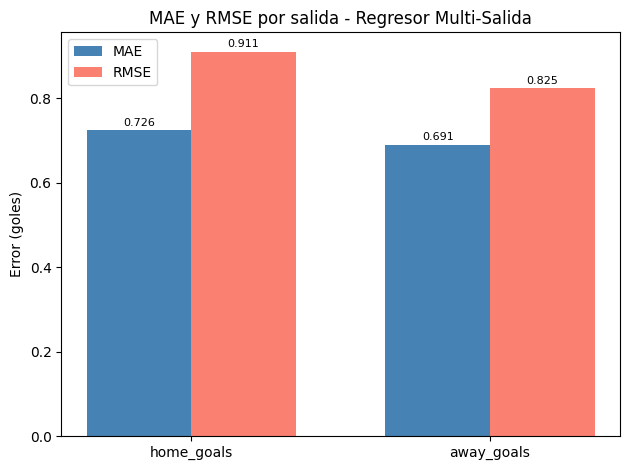

Resultado derivado (multi) - Accuracy: 0.6004, F1-macro: 0.5957
              precision    recall  f1-score   support

           A     0.7252    0.6333    0.6762       150
           D     0.3571    0.5263    0.4255       133
           H     0.7644    0.6213    0.6854       235

    accuracy                         0.6004       518
   macro avg     0.6156    0.5936    0.5957       518
weighted avg     0.6485    0.6004    0.6160       518

Modelo multi-salida guardado en: C:\Users\Ricar\Desktop\Programas\multiprotocol-server-app\training\models\best_model_multioutput_regressor_notebook.joblib


In [27]:
# Grafica comparativa de MAE y RMSE por salida del regresor multi-salida.
labels = ["home_goals", "away_goals"]
mae_vals  = [mae_home, mae_away]
rmse_vals = [mse_home**0.5, mse_away**0.5]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, mae_vals,  width, label="MAE",  color="steelblue")
bars2 = ax.bar(x + width/2, rmse_vals, width, label="RMSE", color="salmon")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Error (goles)")
ax.set_title("MAE y RMSE por salida - Regresor Multi-Salida")
ax.legend()
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.3f}", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

# Convertimos las predicciones continuas de goles a etiquetas de resultado (H/A/D).
# Se redondea al entero mas cercano y se recorta a 0 para evitar goles negativos.
def _goals_to_result(pred_goals):
    preds_rounded = np.rint(pred_goals).astype(int)
    preds_rounded = np.clip(preds_rounded, 0, None)
    res = []
    for h, a in preds_rounded:
        if h > a:
            res.append("H")
        elif h < a:
            res.append("A")
        else:
            res.append("D")
    return np.array(res)

y_pred_result_multi = _goals_to_result(y_pred_goals)

# Calculamos las metricas de clasificacion derivadas para poder comparar este modelo
# con los clasificadores directos usando la misma metrica (f1_macro).
acc_multi = accuracy_score(y_test, y_pred_result_multi)
f1m_multi = f1_score(y_test, y_pred_result_multi, average="macro")

print(f"Resultado derivado (multi) - Accuracy: {acc_multi:.4f}, F1-macro: {f1m_multi:.4f}")
print(classification_report(y_test, y_pred_result_multi, digits=4))


## Seccion 11: Seleccion del Mejor Modelo

In [28]:
# Comparamos los tres candidatos usando f1_macro como metrica comun:
#   - Clasificadores (LR, RF): se usa el best_score_ del GridSearchCV, que corresponde
#     al promedio de f1_macro sobre los 5 folds de validacion.
#   - Regresor multi-salida: se usa el f1_macro calculado sobre el conjunto de prueba
#     a partir del resultado derivado de los goles predichos.
# Se selecciona el candidato con el mayor score y se extrae su best_estimator_.
candidates = [
    ("LogisticRegression",     grid_lr,    grid_lr.best_score_),
    ("RandomForest",           grid_rf,    grid_rf.best_score_),
    ("MultiOutputRegressor",   grid_multi, f1m_multi),
]

best_name, best_obj, best_score = max(candidates, key=lambda x: x[2])

# Si el objeto ganador es un GridSearchCV, extraemos el pipeline ya reentrenado
# sobre todo el conjunto de entrenamiento (refit=True).
if hasattr(best_obj, "best_estimator_"):
    best_model = best_obj.best_estimator_
else:
    best_model = best_obj


In [29]:
# Tabla comparativa de los tres candidatos con sus scores de f1_macro.
# Permite visualizar la diferencia de rendimiento entre modelos antes de elegir el ganador.
comparison_df = pd.DataFrame(
    [(name, score) for name, _, score in candidates],
    columns=["modelo", "f1_macro"]
).sort_values("f1_macro", ascending=False).reset_index(drop=True)

comparison_df["ganador"] = comparison_df["modelo"] == best_name
comparison_df


,modelo,f1_macro,ganador
0,MultiOutputRegressor,0.595712,True
1,LogisticRegression,0.556615,False
2,RandomForest,0.541405,False


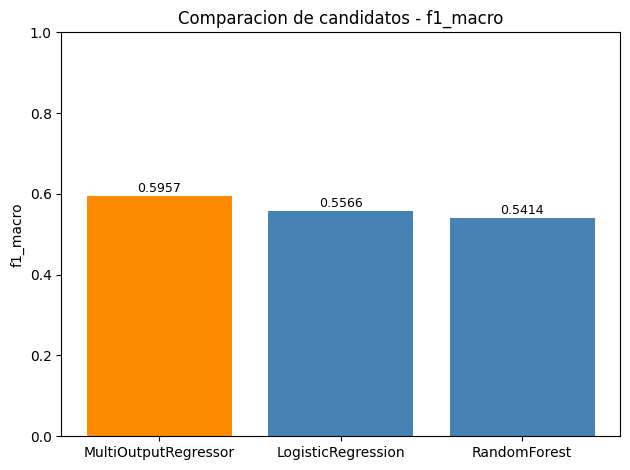

Modelo seleccionado: MultiOutputRegressor (f1_macro = 0.5957)


In [30]:
# Grafica de barras comparativa de f1_macro entre los tres modelos.
# La barra del modelo ganador se resalta en un color distinto.
colors = ["steelblue" if m != best_name else "darkorange" for m in comparison_df["modelo"]]
fig, ax = plt.subplots()
ax.bar(comparison_df["modelo"], comparison_df["f1_macro"], color=colors)
ax.set_ylim(0, 1)
ax.set_ylabel("f1_macro")
ax.set_title("Comparacion de candidatos - f1_macro")
for i, v in enumerate(comparison_df["f1_macro"]):
    ax.text(i, v + 0.01, f"{v:.4f}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

print(f"Modelo seleccionado: {best_name} (f1_macro = {best_score:.4f})")


## Seccion 12: Evaluacion del Modelo Seleccionado en Conjunto de Prueba

In [31]:
# Generamos predicciones del modelo ganador sobre el conjunto de prueba interno.
# Si el modelo es el regresor multi-salida, la salida es (n_samples, 2) con goles
# predichos; en ese caso derivamos el resultado antes de calcular las metricas.
y_pred_raw = best_model.predict(X_test)

if hasattr(y_pred_raw, 'shape') and y_pred_raw.ndim == 2 and y_pred_raw.shape[1] == 2 and np.issubdtype(np.array(y_pred_raw).dtype, np.number):
    y_pred = _goals_to_result(y_pred_raw)
else:
    y_pred = y_pred_raw

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

acc, f1m


(0.6003861003861004, 0.5957115026377272)

In [32]:
# Reporte detallado por clase: precision, recall y f1 para H, A y D.
# Permite identificar en que clases el modelo tiene mayor dificultad (tipicamente D).
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           A     0.7252    0.6333    0.6762       150
           D     0.3571    0.5263    0.4255       133
           H     0.7644    0.6213    0.6854       235

    accuracy                         0.6004       518
   macro avg     0.6156    0.5936    0.5957       518
weighted avg     0.6485    0.6004    0.6160       518



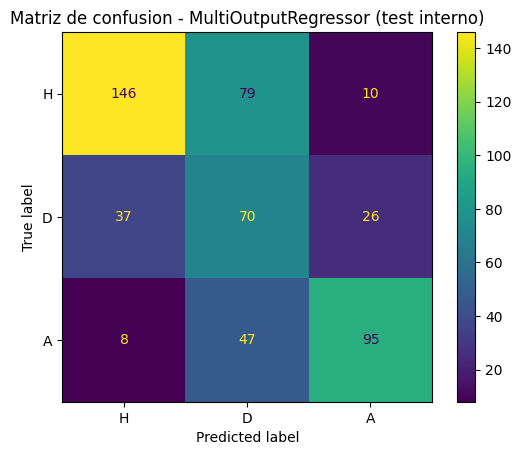

In [33]:
# Matriz de confusion del modelo seleccionado sobre el conjunto de prueba interno.
# Las filas representan clases reales y las columnas clases predichas.
cm = confusion_matrix(y_test, y_pred, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm, display_labels=["H", "D", "A"]).plot()
plt.title(f"Matriz de confusion - {best_name} (test interno)")
plt.show()


In [34]:
# Resumen de scores de entrenamiento y validacion para detectar overfitting.
# mean_train_score y mean_val_score provienen del CV del GridSearch (si aplica).
# train_f1_macro y test_f1_macro se calculan directamente sobre los conjuntos finales.
if hasattr(best_obj, "cv_results_"):
    cv_results = pd.DataFrame(best_obj.cv_results_)
    best_idx = best_obj.best_index_
    mean_train_cv = cv_results.loc[best_idx, "mean_train_score"]
    mean_val_cv   = cv_results.loc[best_idx, "mean_test_score"]
else:
    cv_results    = None
    mean_train_cv = None
    mean_val_cv   = None

# Derivamos el resultado en el conjunto de entrenamiento si el modelo es multi-salida.
train_pred_raw = best_model.predict(X_train)
if hasattr(train_pred_raw, 'shape') and getattr(train_pred_raw, 'ndim', 1) == 2 and train_pred_raw.shape[1] == 2 and np.issubdtype(np.array(train_pred_raw).dtype, np.number):
    train_pred = _goals_to_result(train_pred_raw)
else:
    train_pred = train_pred_raw

train_f1m = f1_score(y_train, train_pred, average="macro")
test_f1m  = f1_score(y_test,  y_pred,     average="macro")

pd.DataFrame({
    "score": ["mean_train_score(CV)", "mean_val_score(CV)", "train_f1_macro", "test_f1_macro"],
    "value": [mean_train_cv, mean_val_cv, train_f1m, test_f1m]
})


,score,value
0,mean_train_score(CV),-0.615570
1,mean_val_score(CV),-0.728366
2,train_f1_macro,0.587167
3,test_f1_macro,0.595712


## Seccion 13: Evaluacion Externa con Datasets Historicos

In [35]:
# Evaluamos el modelo final sobre datasets de temporadas anteriores (2016-2022 y 2016-2023)
# para medir su capacidad de generalizacion a datos fuera del periodo de entrenamiento.

# Funcion auxiliar para cargar, limpiar y preparar cualquier dataset historico
# con el mismo esquema de features y etiquetas que el conjunto de entrenamiento.
def prepare_xy_from_raw(path: str) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    df = pd.read_csv(path)

    keep_cols = [
        "home_team", "away_team",
        "home_win", "away_win",
        "home_goals", "away_goals",
        "home_goals_half_time", "away_goals_half_time",
        "home_goals_fulltime", "away_goals_fulltime",
    ]

    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    score_cols = [
        "home_goals", "away_goals",
        "home_goals_half_time", "away_goals_half_time",
        "home_goals_fulltime", "away_goals_fulltime",
    ]

    for c in score_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["home_team", "away_team", "home_goals_fulltime", "away_goals_fulltime"])

    df["result"] = np.where(
        df["home_goals_fulltime"] > df["away_goals_fulltime"], "H",
        np.where(df["home_goals_fulltime"] < df["away_goals_fulltime"], "A", "D")
    )

    features = ["home_team", "away_team", "home_goals_half_time", "away_goals_half_time"]
    df = df.dropna(subset=features)

    X = df[features].copy()
    y = df["result"].copy()
    return X, y, df

X_2023, y_2023, df_2023 = prepare_xy_from_raw(PATH_RAW_2023)
X_2022, y_2022, df_2022 = prepare_xy_from_raw(PATH_RAW_2022)

# Funcion de evaluacion generica que maneja tanto clasificadores como el regresor multi-salida.
# Si el modelo devuelve dos columnas numericas (goles), deriva el resultado antes de evaluar.
def eval_dataset(name: str, model: Pipeline, Xext: pd.DataFrame, yext: pd.Series) -> dict[str, Any]:
    yhat_raw = model.predict(Xext)
    if hasattr(yhat_raw, 'shape') and getattr(yhat_raw, 'ndim', 1) == 2 and yhat_raw.shape[1] == 2 and np.issubdtype(np.array(yhat_raw).dtype, np.number):
        yhat = _goals_to_result(yhat_raw)
    else:
        yhat = yhat_raw

    return {
        "dataset": name,
        "n": len(yext),
        "accuracy": accuracy_score(yext, yhat),
        "f1_macro": f1_score(yext, yhat, average="macro")
    }

# Tabla comparativa de accuracy y f1_macro sobre los dos datasets externos.
external_report = pd.DataFrame([
    eval_dataset("RAW 2016-2023", best_model, X_2023, y_2023),
    eval_dataset("RAW 2016-2022", best_model, X_2022, y_2022),
])

external_report


,dataset,n,accuracy,f1_macro
0,RAW 2016-2023,2452,0.595432,0.583709
1,RAW 2016-2022,2153,0.601951,0.591738


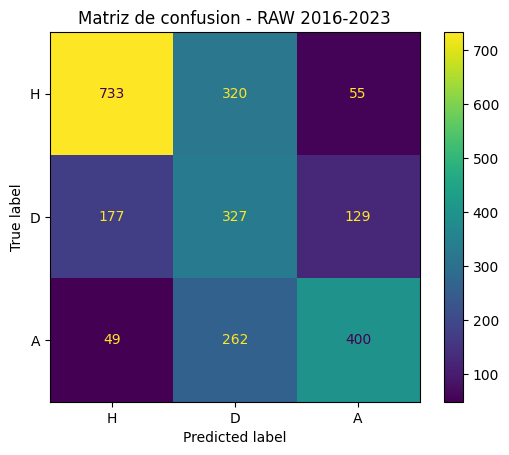

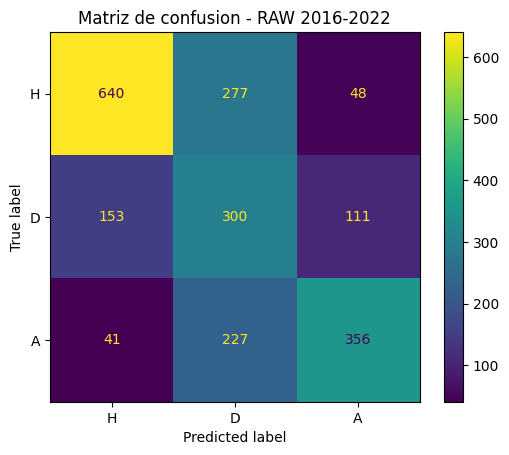

In [36]:
# Matrices de confusion sobre los datasets externos para analizar el comportamiento
# del modelo en cada clase (H/A/D) fuera del periodo de entrenamiento.
yhat_2023 = best_model.predict(X_2023)
if hasattr(yhat_2023, 'shape') and getattr(yhat_2023, 'ndim', 1) == 2 and yhat_2023.shape[1] == 2 and np.issubdtype(np.array(yhat_2023).dtype, np.number):
    yhat_2023 = _goals_to_result(yhat_2023)

cm_2023 = confusion_matrix(y_2023, yhat_2023, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm_2023, display_labels=["H", "D", "A"]).plot()
plt.title("Matriz de confusion - RAW 2016-2023")
plt.show()

yhat_2022 = best_model.predict(X_2022)
if hasattr(yhat_2022, 'shape') and getattr(yhat_2022, 'ndim', 1) == 2 and yhat_2022.shape[1] == 2 and np.issubdtype(np.array(yhat_2022).dtype, np.number):
    yhat_2022 = _goals_to_result(yhat_2022)

cm_2022 = confusion_matrix(y_2022, yhat_2022, labels=["H", "D", "A"])
ConfusionMatrixDisplay(cm_2022, display_labels=["H", "D", "A"]).plot()
plt.title("Matriz de confusion - RAW 2016-2022")
plt.show()


## Seccion 14: Serializacion del Modelo Final

In [39]:
# Exportamos el pipeline completo del modelo ganador (preprocesamiento + estimador)
# como un archivo .joblib listo para ser cargado en el proceso de inferencia.
# El nombre del archivo incluye el tipo de modelo para facilitar su identificacion.
os.makedirs(MODEL_DIR, exist_ok=True)

model_filename: str = f"best_model_{best_name}.joblib"
model_path: str = os.path.join(MODEL_DIR, model_filename)
joblib.dump(best_model, model_path)

print(f"Modelo guardado en: {model_path}")
print(f"Modelo: {best_name}")
print(f"Accuracy (test): {acc:.4f}")
print(f"F1-macro (test): {f1m:.4f}")


Modelo guardado en: C:\Users\Ricar\Desktop\Programas\multiprotocol-server-app\training\models\best_model_MultiOutputRegressor.joblib
Modelo: MultiOutputRegressor
Accuracy (test): 0.6004
F1-macro (test): 0.5957


## Seccion 15: Serializacion Individual por Modelo (Opcional)

Celda de uso opcional para serializar un modelo especifico e independiente del proceso
de seleccion automatica. Util para probar modelos individuales con `training.py`
sin necesidad de re-ejecutar el notebook completo.

Descomentar unicamente el bloque del modelo que se desea exportar.
El archivo generado seguira el patron `best_model_*.joblib` y sera detectado
automaticamente por `find_latest_model()` en `training.py`.

In [38]:
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Modelo 1: Regresion Logistica ---
joblib.dump(grid_lr.best_estimator_, os.path.join(MODEL_DIR, "best_model_LogisticRegression_test.joblib"))
print("Modelo LogisticRegression guardado para pruebas.")

# --- Modelo 2: Random Forest Clasificador ---
joblib.dump(grid_rf.best_estimator_, os.path.join(MODEL_DIR, "best_model_RandomForest_test.joblib"))
print("Modelo RandomForest guardado para pruebas.")

# --- Modelo 3: Regresor Multi-Salida ---
joblib.dump(best_multi, os.path.join(MODEL_DIR, "best_model_MultiOutputRegressor_test.joblib"))
print("Modelo MultiOutputRegressor guardado para pruebas.")



Modelo LogisticRegression guardado para pruebas.
Modelo RandomForest guardado para pruebas.
Modelo MultiOutputRegressor guardado para pruebas.
